1. Load the data

We create the specific text format found on https://cycling.data.tfl.gov.uk/ on the required dates, and load everything into a dataframe.

In [1]:
import pandas as pd
from datetime import date, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# make format number_JourneyDataExtract for dates 2019-2021
numbers = []
for i in range(143,298):
  numbers.append(str(i) + 'JourneyDataExtract')
  if i ==246:                                         # fix duplicate number 246               
    numbers.append(str(i) + 'JourneyDataExtract')

In [2]:
from datetime import date, timedelta

start_date = date(2019, 1, 2)
end_date = date(2021, 12, 28)
delta = timedelta(days=6)
s = 0
dates = []
while start_date <= end_date:
    dates.append(start_date.strftime("%d%b%Y"))
    if s%2!=0:
      delta = timedelta(days=1)
    else:
      delta = timedelta(days=6)
    start_date += delta 
    s+=1

date_tuple = [dates[i]+'-'+ dates[i+1] for i in range(len(dates)) if i%2==0]
len(date_tuple), len(numbers)

(156, 156)

In [3]:
result = [ pd.read_csv('https://cycling.data.tfl.gov.uk/usage-stats/' + numbers[j] + date_tuple[j] + '.csv', index_col=0) for j in range(len(date_tuple)-1)]
df = pd.concat(result)

In [4]:
df.head()

,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
Rental Id,,,,,,,,
83284852,660,8282,02/01/2019 17:47,94,"Bricklayers Arms, Borough",02/01/2019 17:36,197,"Stamford Street, South Bank"
83360769,180,4657,06/01/2019 18:14,94,"Bricklayers Arms, Borough",06/01/2019 18:11,269,"Empire Square, The Borough"
83280311,960,6306,02/01/2019 14:49,374,"Waterloo Station 1, Waterloo",02/01/2019 14:33,5,"Sedding Street, Sloane Square"
83323626,120,6217,04/01/2019 12:54,269,"Empire Square, The Borough",04/01/2019 12:52,94,"Bricklayers Arms, Borough"
83343322,120,848,05/01/2019 16:03,269,"Empire Square, The Borough",05/01/2019 16:01,94,"Bricklayers Arms, Borough"


2. Dataset pre-processing

We process the data such that we have all the features we are going to use ('Season', 'Month', 'Year', 'Duration') along with the variable for prediction 'Count'.

In [5]:
# count per month
df.index = [x for x in range(len(df))]
df['1s'] = [1]*len(df)
count = df.groupby('Start Date')['1s'].sum()
df_count = pd.DataFrame(count)
df_count['Month'] = pd.DatetimeIndex(df_count.index).month
df_count_month = df_count.groupby('Month')['1s'].sum() 
df_count['Season'] = df_count['Month'].apply(lambda x: x%12 // 3 + 1)
df_count_month.head()

Month
1    2131058
2    2181397
3    2282748
4    2489980
5    3070152
Name: 1s, dtype: int64

In [6]:
df.head()

,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,1s
0,660,8282,02/01/2019 17:47,94,"Bricklayers Arms, Borough",02/01/2019 17:36,197,"Stamford Street, South Bank",1
1,180,4657,06/01/2019 18:14,94,"Bricklayers Arms, Borough",06/01/2019 18:11,269,"Empire Square, The Borough",1
2,960,6306,02/01/2019 14:49,374,"Waterloo Station 1, Waterloo",02/01/2019 14:33,5,"Sedding Street, Sloane Square",1
3,120,6217,04/01/2019 12:54,269,"Empire Square, The Borough",04/01/2019 12:52,94,"Bricklayers Arms, Borough",1
4,120,848,05/01/2019 16:03,269,"Empire Square, The Borough",05/01/2019 16:01,94,"Bricklayers Arms, Borough",1


In [7]:
# main bulk of pre-processing
StartStation_Name = df['StartStation Name']
EndStation_Name = df['EndStation Name']
df = df.drop('StartStation Name', axis=1)
df = df.drop('EndStation Name', axis=1)
df = df.drop('Bike Id', axis=1)
df = df.drop('End Date', axis=1)
df['Start Hour'] = df['Start Date'].apply(lambda x: x.split()[1])

In [8]:
df['Start Hour'] = df['Start Hour'].apply(lambda x: x.split(':')[0] + x.split(':')[1])
# df['End Date'] = df['End Date'].apply(lambda x: x.split()[1])
# df['End Date'] = df['End Date'].apply(lambda x: x.split(':')[0] + x.split(':')[1])
df['Duration'] = df['Duration']/60
df['Start Date'] = df['Start Date'].apply(lambda x: x.split()[0])
df['Month'] = pd.DatetimeIndex(df['Start Date'], dayfirst=True).month
df['Year'] = pd.DatetimeIndex(df['Start Date'], dayfirst=True).year
df['Season'] = df['Month'].apply(lambda x: x%12 // 3 + 1)
df.head()

,Duration,EndStation Id,Start Date,StartStation Id,1s,Start Hour,Month,Year,Season
0,11.0,94,02/01/2019,197,1,1736,1,2019,1
1,3.0,94,06/01/2019,269,1,1811,1,2019,1
2,16.0,374,02/01/2019,5,1,1433,1,2019,1
3,2.0,269,04/01/2019,94,1,1252,1,2019,1
4,2.0,269,05/01/2019,94,1,1601,1,2019,1


In [9]:
df.head()

,Duration,EndStation Id,Start Date,StartStation Id,1s,Start Hour,Month,Year,Season
0,11.0,94,02/01/2019,197,1,1736,1,2019,1
1,3.0,94,06/01/2019,269,1,1811,1,2019,1
2,16.0,374,02/01/2019,5,1,1433,1,2019,1
3,2.0,269,04/01/2019,94,1,1252,1,2019,1
4,2.0,269,05/01/2019,94,1,1601,1,2019,1


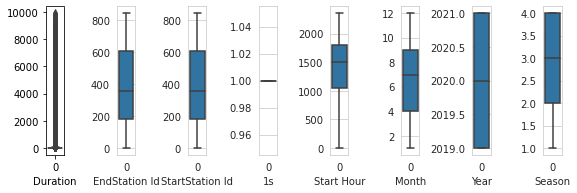

In [10]:
# Boxplot, we see that 'Duration' is heavily off, and we need to take care of the outliers
df_out = df.drop('Start Date', axis=1)
l1 = df_out.columns.values
number_of_columns=8
number_of_rows=1
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l1)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    plt.xlabel(l1[i])
    sns.boxplot(data=df_out[l1[i]], orient='v')
    plt.tight_layout()

Take care of outliers of 'Duration'

In [11]:
q1=df['Duration'].quantile(0.25)
q3=df['Duration'].quantile(0.75)
iqr=q3-q1
dfc = df[(df['Duration'] >= q1 - 1.5*iqr) & (df['Duration'] <= q3 +1.5*iqr)]
dfc.shape

(29037632, 9)

In [12]:
dfc.info()
dfc.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29037632 entries, 0 to 31259719
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Duration         float64
 1   EndStation Id    int64  
 2   Start Date       object 
 3   StartStation Id  int64  
 4   1s               int64  
 5   Start Hour       object 
 6   Month            int64  
 7   Year             int64  
 8   Season           int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 2.2+ GB


,Duration,EndStation Id,StartStation Id,1s,Month,Year,Season
count,2.903763e+07,2.903763e+07,2.903763e+07,29037632.0,2.903763e+07,2.903763e+07,2.903763e+07
mean,1.534095e+01,3.899512e+02,3.912328e+02,1.0,6.763086e+00,2.020007e+03,2.699412e+00
std,8.818137e+00,2.454492e+02,2.451747e+02,0.0,3.121410e+00,8.246195e-01,1.054857e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,2.019000e+03,1.000000e+00
25%,8.000000e+00,1.830000e+02,1.830000e+02,1.0,4.000000e+00,2.019000e+03,2.000000e+00
50%,1.400000e+01,3.560000e+02,3.580000e+02,1.0,7.000000e+00,2.020000e+03,3.000000e+00
75%,2.100000e+01,6.030000e+02,6.040000e+02,1.0,9.000000e+00,2.021000e+03,4.000000e+00
max,4.400000e+01,8.450000e+02,8.450000e+02,1.0,1.200000e+01,2.021000e+03,4.000000e+00


In [13]:
dfc.head()

,Duration,EndStation Id,Start Date,StartStation Id,1s,Start Hour,Month,Year,Season
0,11.0,94,02/01/2019,197,1,1736,1,2019,1
1,3.0,94,06/01/2019,269,1,1811,1,2019,1
2,16.0,374,02/01/2019,5,1,1433,1,2019,1
3,2.0,269,04/01/2019,94,1,1252,1,2019,1
4,2.0,269,05/01/2019,94,1,1601,1,2019,1


At this point, to make the dataset smaller, and to concentrate the results

In [14]:
ucount = dfc.groupby('Start Date')['1s'].sum().apply(lambda x: np.unique(x))
ucount = ucount.apply(lambda x: x[0])
ucount.head()
dframe = pd.Series.to_frame(ucount)
dframe['Duration'] = dfc.groupby('Start Date')['Duration'].sum()
dframe['Count'] = dframe['1s']

In [15]:
dframe.head()

,1s,Duration,Count
Start Date,,,
01/01/2020,9694,156317.0,9694
01/01/2021,9392,167823.0,9392
01/02/2019,12631,149350.0,12631
01/02/2020,18827,274894.0,18827
01/02/2021,11859,178810.0,11859


In [16]:
dframe = dframe.drop('1s', axis=1)
dframe.index = pd.to_datetime(dframe.index, dayfirst=True)
dframe['Year'] = dframe.index.year
dframe['Month'] = dframe.index.month
dframe['Duration'] = dframe['Duration']/60
dframe['Duration'] = dframe['Duration'].astype(int)
dframe['Season'] = dframe['Month'].apply(lambda x: x%12 // 3 + 1)

In [17]:
dframe.shape

(1085, 5)

In [18]:
dframe.head()

,Duration,Count,Year,Month,Season
Start Date,,,,,
2020-01-01,2605,9694,2020,1,1
2021-01-01,2797,9392,2021,1,1
2019-02-01,2489,12631,2019,2,1
2020-02-01,4581,18827,2020,2,1
2021-02-01,2980,11859,2021,2,1


In [19]:
dframe.describe() 

,Duration,Count,Year,Month,Season
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,6842.302304,26762.794470,2019.991705,6.476498,2.517972
std,2658.445800,9083.202591,0.814380,3.423472,1.110541
min,1145.000000,4500.000000,2019.000000,1.000000,1.000000
25%,4999.000000,20459.000000,2019.000000,4.000000,2.000000
50%,6594.000000,27391.000000,2020.000000,6.000000,3.000000
75%,8698.000000,33238.000000,2021.000000,9.000000,4.000000
max,17876.000000,51850.000000,2021.000000,12.000000,4.000000


These are the correct statistics! Mean is around 6500 vs the ~9000 that it would have been, if we first aggregated and didn't take care of outliers.

In [20]:
dframe.index = [i for i in range(len(dframe))]

<AxesSubplot:>

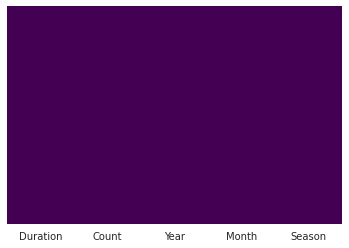

In [21]:
# Check for missing values
sns.heatmap(dframe.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

<AxesSubplot:>

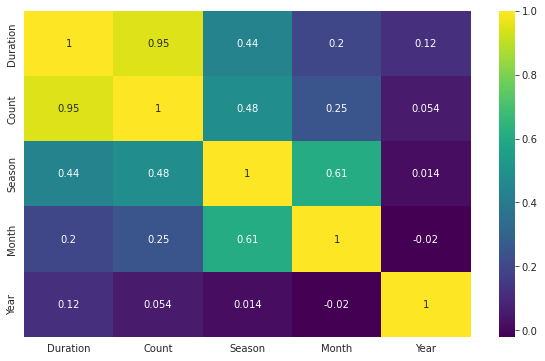

In [22]:
# Quality correlation matrix
k = 5 #number of variables for heatmap
cols = dframe.corr().nlargest(k, 'Duration')['Duration'].index
cm = dframe[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

5. Exploratory Analysis

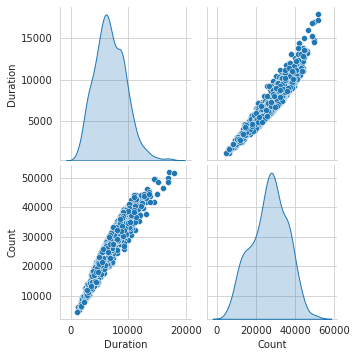

In [23]:
sns.pairplot(dframe[['Duration', 'Count']], diag_kind='kde')
plt.show()

The above plot shows a linear relationship between 'Count' and 'Duration'.

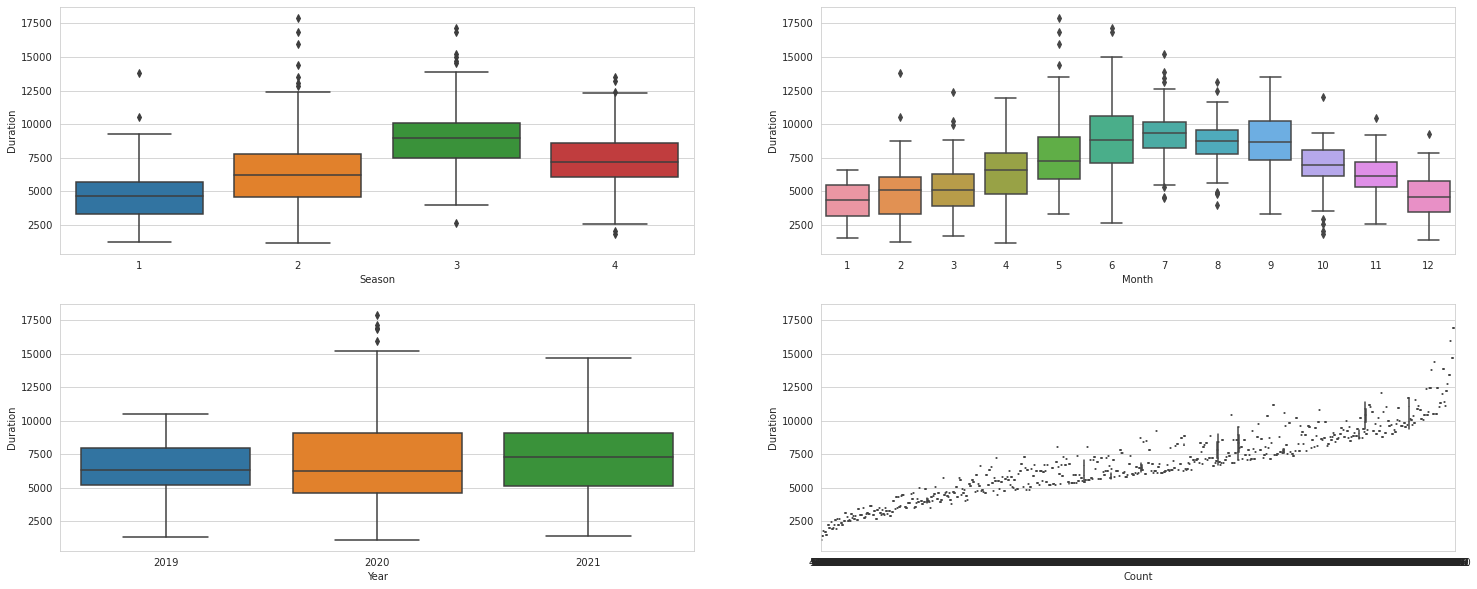

In [24]:
plt.figure(figsize=(25, 10))
plt.subplot(2,2,1)
sns.boxplot(x = 'Season', y = 'Duration', data = dframe)
plt.subplot(2,2,2)
sns.boxplot(x = 'Month', y = 'Duration', data = dframe)
plt.subplot(2,2,3)
sns.boxplot(x = 'Year', y = 'Duration', data = dframe)
plt.subplot(2,2,4)
sns.boxplot(x = 'Count', y = 'Duration', data = dframe)
plt.show()

Insights

There were 5 categorical variables in the dataset.

We used Box plot (refer the fig above) to study their effect on the dependent variable (‘Count’) .

The boxplot shows that 'Season', 'Year', 'Duration' and 'Month' could be good variables to predict 'Count'.

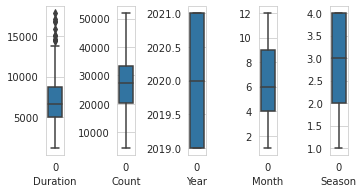

In [25]:
l = dframe.columns.values
number_of_columns=7
number_of_rows=1
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    plt.xlabel(l[i])
    sns.boxplot(data=dframe[l[i]], orient='v')
    plt.tight_layout()

In the above boxplot, we see how these 5 features are spread. 

6. Data Science modelling

First, let's create dummy variables to include month1, ..., month12, season1, ..., season4, year1, ..., year3 as distinct variables in our linear model.

In [26]:
df_new=dframe[['Season', 'Year', 'Month', 'Count', 'Duration',]]

In [27]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Season    1085 non-null   int64
 1   Year      1085 non-null   int64
 2   Month     1085 non-null   int64
 3   Count     1085 non-null   int64
 4   Duration  1085 non-null   int64
dtypes: int64(5)
memory usage: 83.1 KB


In [28]:
df_new['Season']=df_new['Season'].astype('category')
df_new['Month']=df_new['Month'].astype('category')
df_new['Year']=df_new['Year'].astype('category')

In [29]:
df_new.head()

,Season,Year,Month,Count,Duration
0,1,2020,1,9694,2605
1,1,2021,1,9392,2797
2,1,2019,2,12631,2489
3,1,2020,2,18827,4581
4,1,2021,2,11859,2980


In [30]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Season    1085 non-null   category
 1   Year      1085 non-null   category
 2   Month     1085 non-null   category
 3   Count     1085 non-null   int64   
 4   Duration  1085 non-null   int64   
dtypes: category(3), int64(2)
memory usage: 61.6 KB


In [31]:
df_new = pd.get_dummies(df_new, drop_first=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Count      1085 non-null   int64
 1   Duration   1085 non-null   int64
 2   Season_2   1085 non-null   uint8
 3   Season_3   1085 non-null   uint8
 4   Season_4   1085 non-null   uint8
 5   Year_2020  1085 non-null   uint8
 6   Year_2021  1085 non-null   uint8
 7   Month_2    1085 non-null   uint8
 8   Month_3    1085 non-null   uint8
 9   Month_4    1085 non-null   uint8
 10  Month_5    1085 non-null   uint8
 11  Month_6    1085 non-null   uint8
 12  Month_7    1085 non-null   uint8
 13  Month_8    1085 non-null   uint8
 14  Month_9    1085 non-null   uint8
 15  Month_10   1085 non-null   uint8
 16  Month_11   1085 non-null   uint8
 17  Month_12   1085 non-null   uint8
dtypes: int64(2), uint8(16)
memory usage: 74.7 KB


Below, we will try and find which variables help us predict an increase in the 'Count' of bikes. 

First, we split the data we've seen so far into training and test data [70/30] using train_test_split method from sklearn package for this.


In [32]:
df_new.shape

(1085, 18)

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Count      1085 non-null   int64
 1   Duration   1085 non-null   int64
 2   Season_2   1085 non-null   uint8
 3   Season_3   1085 non-null   uint8
 4   Season_4   1085 non-null   uint8
 5   Year_2020  1085 non-null   uint8
 6   Year_2021  1085 non-null   uint8
 7   Month_2    1085 non-null   uint8
 8   Month_3    1085 non-null   uint8
 9   Month_4    1085 non-null   uint8
 10  Month_5    1085 non-null   uint8
 11  Month_6    1085 non-null   uint8
 12  Month_7    1085 non-null   uint8
 13  Month_8    1085 non-null   uint8
 14  Month_9    1085 non-null   uint8
 15  Month_10   1085 non-null   uint8
 16  Month_11   1085 non-null   uint8
 17  Month_12   1085 non-null   uint8
dtypes: int64(2), uint8(16)
memory usage: 74.7 KB


In [34]:
from sklearn.model_selection import train_test_split

# We should specify 'random_state' so that the train and test data set always have the same rows, respectively

np.random.seed(0)
df_train, df_test = train_test_split(df_new, train_size = 0.70, test_size = 0.30, random_state = 333)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 405 to 973
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Count      759 non-null    int64
 1   Duration   759 non-null    int64
 2   Season_2   759 non-null    uint8
 3   Season_3   759 non-null    uint8
 4   Season_4   759 non-null    uint8
 5   Year_2020  759 non-null    uint8
 6   Year_2021  759 non-null    uint8
 7   Month_2    759 non-null    uint8
 8   Month_3    759 non-null    uint8
 9   Month_4    759 non-null    uint8
 10  Month_5    759 non-null    uint8
 11  Month_6    759 non-null    uint8
 12  Month_7    759 non-null    uint8
 13  Month_8    759 non-null    uint8
 14  Month_9    759 non-null    uint8
 15  Month_10   759 non-null    uint8
 16  Month_11   759 non-null    uint8
 17  Month_12   759 non-null    uint8
dtypes: int64(2), uint8(16)
memory usage: 29.6 KB


In [36]:
df_train.shape

(759, 18)

In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 5 to 301
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Count      326 non-null    int64
 1   Duration   326 non-null    int64
 2   Season_2   326 non-null    uint8
 3   Season_3   326 non-null    uint8
 4   Season_4   326 non-null    uint8
 5   Year_2020  326 non-null    uint8
 6   Year_2021  326 non-null    uint8
 7   Month_2    326 non-null    uint8
 8   Month_3    326 non-null    uint8
 9   Month_4    326 non-null    uint8
 10  Month_5    326 non-null    uint8
 11  Month_6    326 non-null    uint8
 12  Month_7    326 non-null    uint8
 13  Month_8    326 non-null    uint8
 14  Month_9    326 non-null    uint8
 15  Month_10   326 non-null    uint8
 16  Month_11   326 non-null    uint8
 17  Month_12   326 non-null    uint8
dtypes: int64(2), uint8(16)
memory usage: 12.7 KB


In [38]:
df_test.shape

(326, 18)

In [39]:
df_train.columns

Index(['Count', 'Duration', 'Season_2', 'Season_3', 'Season_4', 'Year_2020',
       'Year_2021', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

Let's see which variables are correlated

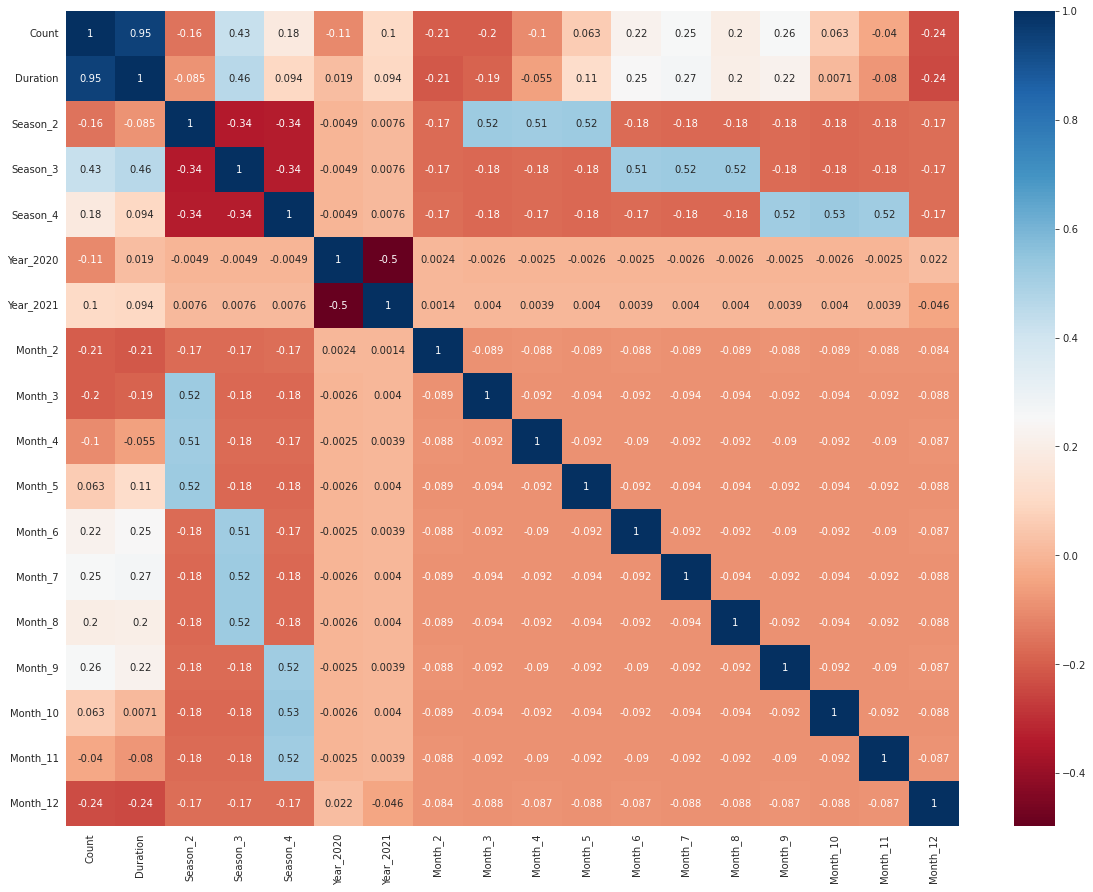

In [40]:
plt.figure(figsize = (20,15))
sns.heatmap(df_new.corr(), annot = True, cmap="RdBu")
plt.show()

Insights

The heatmap shows some multicollinearity of the variables with the target variable.

We will refer this map back-and-forth while building the linear model so as to validate different correlated values along with VIF & p-value, for identifying the correct variable to select/eliminate from the model.

Let's rescale features

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_vars = df_train.columns.values

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,Count,Duration,Season_2,Season_3,Season_4,Year_2020,Year_2021,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
405,0.354446,0.378847,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.493347,0.320615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
140,0.513200,0.326245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125,0.785576,0.586565,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
352,0.612862,0.487741,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
df_train.head()

,Count,Duration,Season_2,Season_3,Season_4,Year_2020,Year_2021,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
405,0.354446,0.378847,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.493347,0.320615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
140,0.513200,0.326245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125,0.785576,0.586565,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
352,0.612862,0.487741,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Get ready for X, Y for linear model

In [43]:
y_train = df_train.pop('Duration')
X_train = df_train

RFE
Recursive feature elimination: We will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)


In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [45]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [46]:
X_train.columns[~rfe.support_]

Index(['Season_2', 'Season_4', 'Month_2', 'Month_3', 'Month_7', 'Month_8',
       'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

In [47]:
# Creating X_test dataframe with RFE selected variables
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

In [48]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Count,4.17
1,Season_3,2.55
3,Year_2021,1.70
2,Year_2020,1.57
6,Month_6,1.49
7,Month_9,1.30
5,Month_5,1.22
4,Month_4,1.14


Below 5, seems good. 

In [49]:
import statsmodels.api as sm

X_train = X_train_rfe

# Add a constant
X_trainlm1 = sm.add_constant(X_train)

# Create a first fitted model
lr1 = sm.OLS(y_train, X_trainlm1).fit()
# Check the parameters obtained

lr1.params

const       -0.055958
Count        0.780091
Season_3     0.035897
Year_2020    0.053379
Year_2021    0.028031
Month_4      0.040354
Month_5      0.045046
Month_6      0.017002
Month_9      0.014871
dtype: float64

In [50]:
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1207.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:28:11   Log-Likelihood:                 1301.3
No. Observations:                 759   AIC:                            -2585.
Df Residuals:                     750   BIC:                            -2543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0560      0.005    -11.008      0.0

Removing 'Month_5' based on p-value>5% (set by the author).

In [51]:
X_train_new = X_train.drop(["Month_5"], axis = 1)

In [52]:
# Add a constant
X_train_lm2 = sm.add_constant(X_train_new)

# Create a first fitted model
lr2 = sm.OLS(y_train, X_train_lm2).fit()

In [53]:
# Check the parameters obtained
lr2.params

const       -0.055751
Count        0.796483
Season_3     0.026043
Year_2020    0.053491
Year_2021    0.026695
Month_4      0.033938
Month_6      0.017052
Month_9      0.004936
dtype: float64

In [54]:
# Print a summary of the linear regression model obtained
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1282.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        14:28:11   Log-Likelihood:                 1275.1
No. Observations:                 759   AIC:                            -2534.
Df Residuals:                     751   BIC:                            -2497.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0558      0.005    -10.602      0.0

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,10.21
2,Season_3,1.81
1,Count,1.45
6,Month_6,1.36
3,Year_2020,1.31
4,Year_2021,1.30
7,Month_9,1.18
5,Month_4,1.05


Model summary and VIF are good, so we can move on

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

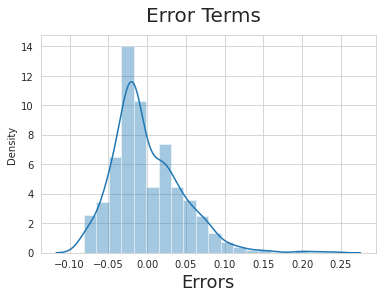

In [56]:
y_train_pred = lr2.predict(X_train_lm2)
res = y_train-y_train_pred
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

Error terms seem to be approximately normally distributed, as they should in a LM. 

Also, we check the qqplot.

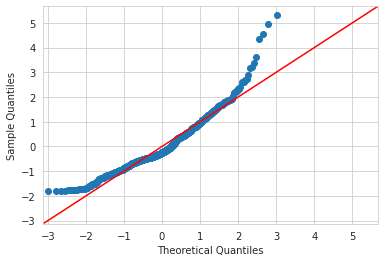

In [57]:
import statsmodels.api as sm
sm.qqplot(res,fit=True,line='45')
plt.show()

Both give us the green light for proceeding with the linear model.

7. Test data performance

In [58]:
df_test.head()

,Count,Duration,Season_2,Season_3,Season_4,Year_2020,Year_2021,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
5,27146,6052,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
126,36910,11147,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
379,37334,10440,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
661,28289,6724,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
222,18500,4617,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [59]:
df_test['Duration'] = scaler.fit_transform(df_test[['Duration']]).flatten()
df_test['Count'] = scaler.fit_transform(df_test[['Count']]).flatten()
df_test.head()

,Count,Duration,Season_2,Season_3,Season_4,Year_2020,Year_2021,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
5,0.472830,0.283698,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
126,0.682795,0.592355,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
379,0.691912,0.549524,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
661,0.497409,0.324408,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
222,0.286906,0.196765,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [60]:
# Dividing into X_test and y_test¶
y_test = df_test.pop('Duration')
X_test = df_test
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 5 to 301
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Count      326 non-null    float64
 1   Season_2   326 non-null    uint8  
 2   Season_3   326 non-null    uint8  
 3   Season_4   326 non-null    uint8  
 4   Year_2020  326 non-null    uint8  
 5   Year_2021  326 non-null    uint8  
 6   Month_2    326 non-null    uint8  
 7   Month_3    326 non-null    uint8  
 8   Month_4    326 non-null    uint8  
 9   Month_5    326 non-null    uint8  
 10  Month_6    326 non-null    uint8  
 11  Month_7    326 non-null    uint8  
 12  Month_8    326 non-null    uint8  
 13  Month_9    326 non-null    uint8  
 14  Month_10   326 non-null    uint8  
 15  Month_11   326 non-null    uint8  
 16  Month_12   326 non-null    uint8  
dtypes: float64(1), uint8(16)
memory usage: 10.2 KB


In [61]:
#Selecting the variables that were part of final model.
col1=X_train_lm2.drop('const', axis=1).columns
X_test=X_test[col1]
# Adding constant variable to test dataframe
X_test = sm.add_constant(X_test)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 5 to 301
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   const      326 non-null    float64
 1   Count      326 non-null    float64
 2   Season_3   326 non-null    uint8  
 3   Year_2020  326 non-null    uint8  
 4   Year_2021  326 non-null    uint8  
 5   Month_4    326 non-null    uint8  
 6   Month_6    326 non-null    uint8  
 7   Month_9    326 non-null    uint8  
dtypes: float64(2), uint8(6)
memory usage: 9.6 KB


In [62]:
X_test.describe()

,const,Count,Season_3,Year_2020,Year_2021,Month_4,Month_6,Month_9
count,326.0,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,1.0,0.465613,0.230061,0.349693,0.365031,0.085890,0.073620,0.107362
std,0.0,0.203427,0.421519,0.477606,0.482179,0.280632,0.261552,0.310049
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.320538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.476668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.620277,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
y_pred = lr2.predict(X_test)

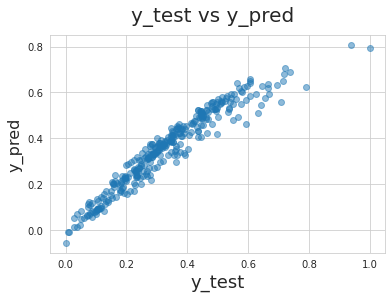

In [64]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred, alpha=.5)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

In [65]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

0.9083885419095608

In [66]:
X_test.shape

(326, 8)

In [67]:
# n is number of rows in X

n = X_test.shape[0]


# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# We find the Adjusted R-squared using the formula

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.9060765808221048